# Capacitated Facility Location Problem - Version #3

The code kind of work atm. However, the constraints need to be improved. The problem is considered infeasible if not all of the farms can be assigned to a plant. 
https://www.youtube.com/watch?v=Ds5whiQXdbw&ab_channel=Hakeem-Ur-Rehman

Multi-source version

In [3]:
# from pulp import *
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np
%matplotlib inline

In [4]:
version_number = 3

In [5]:
# Import farm_cluster_mock_5 dataset - which is the mock data for potential digester locations
potential_digester_location = pd.read_csv(r'./farm_cluster_mock_5.csv')
potential_digester_location.head()

,x,y,count
0,6.870686,52.215190,25
1,6.554937,52.254895,25
2,6.730518,52.252885,42
3,6.914234,52.387401,18
4,6.664105,52.392622,32


In [6]:
# Define the capacities of digester
medium_digester_capacity = 7848  # in tonne/yr
large_digester_capacity = 15056  # in tonne/yr

In [7]:
# Define the costs of digester 
medium_digester_cost = 209249   # in euro CAPEX
large_digester_cost = 252616    # in euro CAPEX

In [8]:
potential_digester_location = potential_digester_location.drop(['count'], axis=1) # drop unnecessary column

In [9]:
# Create mock digester capacity data
potential_digester_location['capacity'] = [medium_digester_capacity, medium_digester_capacity, large_digester_capacity, large_digester_capacity, large_digester_capacity]

# Create mock digester cost data
potential_digester_location['cost'] = [medium_digester_cost, medium_digester_cost, large_digester_cost, large_digester_cost, large_digester_cost]

In [10]:
farm = pd.read_csv(r"./farm_mock.csv")
farm.head()

,Unnamed: 0,x,y,IND_OBJ_NA,manure_t,biogas_potential_m3
0,0,6.765843,52.314139,507920,2454,957060.0
1,1,6.837249,52.425084,507950,9827,3832530.0
2,2,6.859361,52.386225,507953,8660,3377400.0
3,3,6.753483,52.434382,507962,2913,1136070.0
4,4,6.484077,52.243620,507964,6488,2530320.0


In [11]:
farm = pd.DataFrame(farm.sample(n=15, random_state=42))
farm

,Unnamed: 0,x,y,IND_OBJ_NA,manure_t,biogas_potential_m3
131,271,6.779408,52.170940,507739,7242,2824380.0
19,19,6.924298,52.208248,510610,7197,2806830.0
81,157,6.867179,52.238185,ENS01005,444,173160.0
96,191,6.660532,52.198912,HOF01023,8085,3153150.0
56,111,6.462510,52.279628,22215,5790,2258100.0
12,12,6.988119,52.375898,508948,2968,1157520.0
98,194,6.588357,52.235362,HOF01031,6758,2635620.0
65,131,6.634887,52.351974,ALM01090,7989,3115710.0
66,132,6.644223,52.354599,ALM01092,9201,3588390.0
18,18,6.851862,52.253702,510605,5506,2147340.0


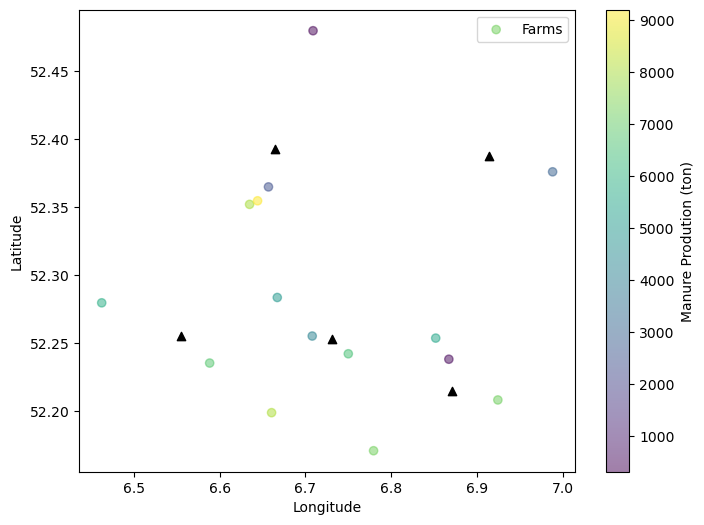

In [12]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(farm['x'], farm['y'], c=farm['manure_t'], alpha=0.5, label="Farms")
plt.scatter(potential_digester_location['x'], potential_digester_location['y'], marker='^', c='black')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.title('Farm Clusters and Cluster Centroids')
cbar = plt.colorbar(scatter)

# Add labels to the colorbar
cbar.set_label('Manure Prodution (ton)')
plt.legend()
plt.show()

In [13]:
# Lists (sets / Array) of Customers and Facilities
Farm = farm.index.tolist()  # Customer = [1,2,3,4,5]
Plant = potential_digester_location.index.tolist()    # Facility = ['Fac-1', 'Fac-2', 'Fac-3']

In [14]:
# Dictionaries of the demands and facilities as well as fixed cost at each facility
Manure_Production = farm['manure_t'].to_dict()  # Demand = {1 : 80, 2 : 270, 3 : 250, 4 : 160, 5 : 180}
Max_Capacity = potential_digester_location['capacity'].to_dict()    # Max_Supply = {'Fac-1' : 500, 'Fac-2' : 500, 'Fac-3' : 500} 
Fixed_Cost = potential_digester_location['cost'].to_dict()  # fixed_cost = {'Fac-1' : 1000, 'Fac-2' : 1000, 'Fac-3' : 1000 }

In [15]:
type(Fixed_Cost.values())

dict_values

In [ ]:
# string_values = {}
# non_string_values = {}

# for key, value in transportation_cost.items():
#     if isinstance(value, str):
#         string_values[key] = value
#     else:
#         non_string_values[key] = value

# print("String Values:")
# print(string_values)

# print("\nNon-String Values:")
# print(non_string_values)

In [16]:
from scipy.spatial.distance import euclidean

# # Dictionary of the transportation cost from each facility to all the customers 
# transportation_cost = {'Fac-1' : {1 : 4, 2 : 5, 3 : 6, 4 : 8, 5 : 10},
#                        'Fac-2' : {1 : 6, 2 : 4, 3 : 3, 4 : 5, 5 : 8},
#                        'Fac-3' : {1 : 9, 2 : 7, 3 : 4, 4 : 3, 5 : 4}
#                       }

# Create a mock distance matrix to store the euclidean distance between each potential digester location to every farm
transportation_cost = {} # NOTE THE TRANSPORTATION COST MATRIX IS A !DISTANCE MATRIX!

for plant_idx, plant_row in potential_digester_location.iterrows():
    plant_coords = (plant_row['y'], plant_row['x'])
    transportation_cost[plant_idx] = {}  # Create an inner dictionary for each plant

    for farm_idx, farm_row in farm.iterrows():
        farm_coords = (farm_row['y'], farm_row['x'])
        distance = euclidean(plant_coords, farm_coords)
        transportation_cost[plant_idx][farm_idx] = distance

# transportation_cost

In [17]:
transportation_cost

{0: {131: 0.10143763837919308,
  19: 0.0540602560720638,
  81: 0.023260882330908,
  96: 0.210783351572384,
  56: 0.4132306151888448,
  12: 0.19904179952420914,
  98: 0.28304828359567585,
  65: 0.27260067724489606,
  66: 0.2659324733973019,
  18: 0.042866473316613245,
  51: 0.21467929539420488,
  77: 0.16761691518455277,
  93: 0.12370424143607356,
  115: 0.3099732388029203,
  130: 0.2609370460876946},
 1: {131: 0.23965750449422538,
  19: 0.3722948969143219,
  81: 0.3126889157023829,
  96: 0.11951712634628293,
  56: 0.09567928662647734,
  12: 0.4497645328906547,
  98: 0.03870952255884493,
  65: 0.12576303097503136,
  66: 0.13383927379580296,
  18: 0.29692692229531265,
  51: 0.11583948748357116,
  77: 0.1529814181466763,
  93: 0.19543900367078507,
  115: 0.27235019407495753,
  130: 0.14992901751703885},
 2: {131: 0.0954213724570846,
  19: 0.1988549599338388,
  81: 0.13744976863897007,
  96: 0.08838089110407889,
  56: 0.26933883638738765,
  12: 0.2854654779459576,
  98: 0.14323682286764078

In [ ]:
# def replace_values_with_2(d):
#     if isinstance(d, dict):
#         return {key: replace_values_with_2(value) for key, value in d.items()}
#     else:
#         return 2
    
# copy_dict = replace_values_with_2(transportation_cost)

# transportation_cost = copy_dict
# print(transportation_cost)

In [ ]:
# Define the total manure production by all farms
Total_Manure_Production = sum(Manure_Production[i] for i in Farm)

In [ ]:
# Define the manure utilization goal
manure_utilization_goal = 0.7

In [ ]:
# Setting the Problem
prob = LpProblem("Capacitated_Facility_Location_Problem_V1", LpMinimize)

In [47]:
# Defining our Decision Variables
use_plant = LpVariable.dicts("Plant", Plant, 0, 1, LpBinary)    
ser_farm = LpVariable.dicts("Farm_Plant", [(i,j) for i in Farm for j in Plant], 0)  

In [48]:
# Define binary decision variables for farm assignment
farm_assignment = LpVariable.dicts("Farm_Assignment", Farm, 0, 1, LpBinary)

# # Create a binary variable to indicate if a farm supplies a plant
# farm_supplies_plant = LpVariable.dicts("Farm_Supplies_Plant", [(i, j) for i in Farm for j in Plant], 0, 1, LpBinary)

In [49]:
# Setting the Objective Function
# prob += lpSum(Fixed_Cost[j]*use_plant[j] for j in Plant) + lpSum(transportation_cost[j][i]*ser_farm[(i,j)] for j in Plant for i in Farm)

prob += lpSum(Fixed_Cost[j]*use_plant[j] for j in Plant) + lpSum(transportation_cost[j][i]*ser_farm[(i,j)] for j in Plant for i in Farm)

    # prob += lpSum(fixed_cost[j]*use_facility[j] for j in Facility) + lpSum(transportation_cost[j][i]*ser_customer[(i,j)] for j in Facility for i in Customer)

In [50]:
# for j in Plant:
#     for i in Farm:
#        print(transportation_cost[j][i]*ser_farm[(i,j)])

In [51]:
# # Costraints

# # This constraint controls that the facility should meet the demand of a customer in the example but in our case
# #     # this means the farm has to be able to send exactly the entire produced amount of manure to the assigned digester


# Constraint
for i in Farm:
    # Total service from facilities to each farm is equal to the farm's production capacity if it is assigned
    prob += lpSum(ser_farm[(i, j)] for j in Plant) == Manure_Production[i] * farm_assignment[i]

# for i in Farm: 
#     prob += lpSum(ser_farm[(i,j)] for j in Plant) == Manure_Production[i]

for j in Plant:
    prob += lpSum(ser_farm[(i,j)] for i in Farm) <= Max_Capacity[j]*use_plant[j]

for i in Farm:
    for j in Plant:
        prob += ser_farm[(i,j)] <= Manure_Production[i]*use_plant[j]

# Add a constraint to ensure at least 50% of total production is sent to plants
prob += lpSum(ser_farm[(i, j)] for i in Farm for j in Plant) >= manure_utilization_goal * Total_Manure_Production

In [52]:
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/wenyuc/opt/anaconda3/envs/bioze_env/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/cb87cbf1d86f4fae960f937d16459a84-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/cb87cbf1d86f4fae960f937d16459a84-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 101 COLUMNS
At line 617 RHS
At line 714 BOUNDS
At line 735 ENDATA
Problem MODEL has 96 rows, 95 columns and 395 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 983040 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 6 strengthened rows, 0 substitutions
Cgl0004I processed model has 96 rows, 95 columns (20 integer (20 of which binary)) and 395 elements
Cbc0038I Initial state - 6 integers unsatisfied sum - 1.04307
Cbc003

1

In [53]:
status = LpStatus[prob.status]


In [54]:
print("Solution Status = ", LpStatus[prob.status])

Solution Status =  Optimal


In [55]:
# if status == "Optimal":
#     # Retrieve and store the variable values
#     optimal_x = use_facility.varValue
#     optimal_y = ser_customer.varValue

#     # Retrieve and store the optimal objective value
#     optimal_obj_value = prob.objective.value()
# else:
#     optimal_x = None
#     optimal_y = None
#     optimal_obj_value = None

# print("Optimization Status:", status)
# print("Optimal x:", optimal_x)
# print("Optimal y:", optimal_y)
# print("Optimal Objective Value:", optimal_obj_value)

In [56]:
# # Print the status of the optimization
# print("Optimization Status:", LpStatus[prob.status])

# # Print the optimal values of decision variables
# for j in Facility:
#     print(f"Use Facility {j}: {use_facility[j].varValue}")

# for i in Customer:
#     for j in Facility:
#         print(f"Service customer {i} from Facility {j}: {ser_customer[(i, j)].varValue}")

In [57]:
# # Print the solution of Binary Decision Variables
# Tolerance = 0.0001
# for j in Plant:
#     if use_plant[j].varValue > Tolerance:
#         print("Estalish Facility at site = ", j)

In [58]:
# Print the solution of Continuous Decision Variables
# for v in prob.variables():
#     print(v.name, "=", v.varValue)

In [59]:
# Initialize lists to store assignment information
assigned_farms = {j: [] for j in Plant}

# Collect assigned farms
for i in Plant:
    for j in Farm:
        if ser_farm[(j,i)].varValue > 0.00001:
            assigned_farms[i].append(j)

In [60]:
# assignment_matrix = pd.DataFrame(index=facilities, columns=customers)

# for i in facilities:
#     for j in customers:
#         assignment_matrix.at[i, j] = x[(i, j)].varValue

assignment_matrix = pd.DataFrame(index=Farm, columns=Plant)

for i in Plant:
    for j in Farm:
        assignment_matrix.at[j, i] = ser_farm[(j, i)].varValue

assignment_matrix

,0,1,2,3,4
131,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0
81,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0
56,0.0,2558.0,0.0,0.0,0.0
12,0.0,0.0,0.0,8334.0,0.0
98,0.0,5290.0,329.0,0.0,0.0
65,0.0,0.0,0.0,0.0,9669.0
66,0.0,0.0,0.0,0.0,0.0
18,7848.0,0.0,223.0,1425.0,0.0


In [61]:
Manure_Production[81]

2274

In [62]:
# Check if the opened plants are under-utilized
potential_digester_location['allocated_manure'] = assignment_matrix.sum(axis = 0)
potential_digester_location

,x,y,capacity,cost,allocated_manure,percentage_utilized
0,6.870686,52.215190,7848,209249,7848.0,0.000000
1,6.554937,52.254895,7848,209249,7848.0,0.000000
2,6.730518,52.252885,15056,252616,15056.0,100.000000
3,6.914234,52.387401,15056,252616,9759.0,66.790648
4,6.664105,52.392622,15056,252616,13512.0,89.744952


In [63]:
# Find the percentage of plant's capacity that is utilized 

potential_digester_location['percentage_utilized'] = 0

for index, row in potential_digester_location.iterrows():
    if row['allocated_manure'] > 0:
        potential_digester_location.at[index, 'percentage_utilized'] = (row['allocated_manure'] / row['capacity']) * 100

In [64]:
def find_farm_not_in_solution_plant_in_solution(solution_dictionary, farm_df):
    """
    Input:
        solution_dictionary: dictionary of model output {plant:[all the assigned farms]}
        farm_df: DataFrame of farm data

    Return:
        empty_keys_unused_plant: a list of indices of unused plants
        farm_not_in_solution: a list of indices of excluded farms
    """
    
    # Find plants that in the optimal solution
    plant_in_use = []
    
    for key, value in solution_dictionary.items():
        if value is not None and not (
            (isinstance(value, str) and value.strip() == '') or
            (isinstance(value, (list, dict)) and not value)
        ):
            plant_in_use.append(key)
    
    # Find farms that are excluded in the optimal solution aka. it is not assigned to any plants
    # Append the lists from the dictionary to a combined list
    combined_dict = []

    for key in solution_dictionary:
        combined_dict.extend(solution_dictionary[key])
    
    farm_not_in_solution = []

    for index_value in farm_df.index:
        if index_value not in combined_dict:
            farm_not_in_solution.append(index_value)
    
    return plant_in_use, farm_not_in_solution 

In [65]:
plant_in_use, farm_not_in_solution = find_farm_not_in_solution_plant_in_solution(assigned_farms, farm)

In [66]:
# # Count the number of farms assigned to each plant
# for j in Plant:
#     assigned = assigned_farms[j]
#     print(len(assigned))

In [67]:
# # Check the indices of farms assigned to each plant
# for j in Plant:
#     assigned = assigned_farms[j]
#     print(assigned)

PROBLEM!! The number of farms that are not_in_any_solution combined with all the farms that are included add up to 143, which is 1 more than the actual count of farms....

Just checked and *18* has duplicates. So Farm 18 is assigned to Plant 1 and 4. 


In [68]:
# Check duplicates

# Initialize a dictionary to store seen values
seen = {}
# Initialize a list to store duplicate values
duplicates = []

# Iterate through the list
for item in farm_not_in_solution:
    # If the item is already in the dictionary, it's a duplicate
    if item in seen:
        duplicates.append(item)
    else:
        seen[item] = True

if duplicates:
    print("Duplicate values:", duplicates)
else:
    print("There are no duplicates in the list.")

There are no duplicates in the list.


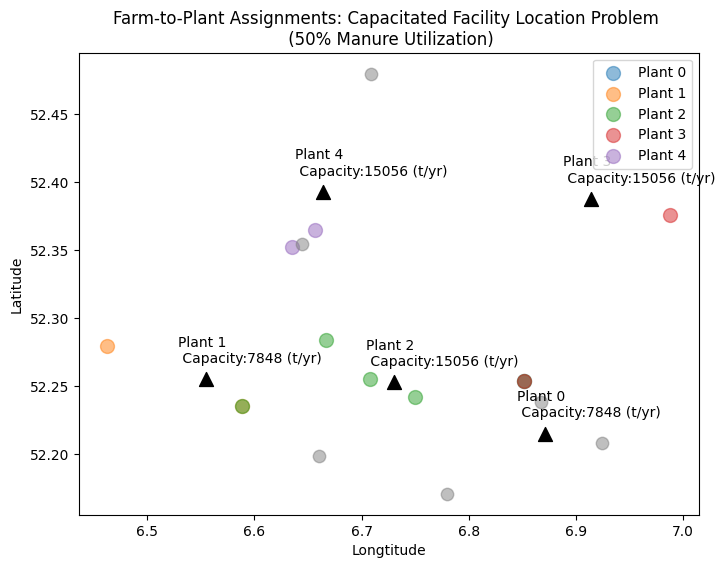

In [69]:
# Visualize the results
plt.figure(figsize=(8, 6))

# Plot plants in solution
# for i in plant_in_use:
#     plt.scatter(potential_digester_location.loc[i, 'x'], potential_digester_location.loc[i, 'y'], marker="^", s=50, c='Black')
#     label = f"Plant {i} \n Capacity:{potential_digester_location.loc[i, 'capacity']} (t/yr)"
#     plt.annotate(label, # this is the text
#                  (potential_digester_location.loc[i, 'x'], potential_digester_location.loc[i, 'y']), # these are the coordinates to position the label
#                  textcoords="offset points", # how to position the text
#                  xytext=(-20,10), # distance from text to points (x,y)
#                  ha='left', va='bottom') # horizontal alignment can be left, right or center
    
for i in Plant:
    plt.scatter(potential_digester_location.loc[i, 'x'], potential_digester_location.loc[i, 'y'], marker="^", s=100, c='Black')
    label = f"Plant {i} \n Capacity:{potential_digester_location.loc[i, 'capacity']} (t/yr)"
    plt.annotate(label, # this is the text
                 (potential_digester_location.loc[i, 'x'], potential_digester_location.loc[i, 'y']), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-20,10), # distance from text to points (x,y)
                 ha='left', va='bottom') # horizontal alignment can be left, right or center 

# Plot farms in solution
for j in Plant:
    assigned = assigned_farms[j]
    plt.scatter([farm.loc[i, 'x'] for i in assigned], [farm.loc[i, 'y'] for i in assigned], label=f"Plant {j}", marker='o', s=100, alpha=0.5)

# Plot farms excluded in solution
for i in farm_not_in_solution:
    plt.scatter(farm.loc[i, 'x'], farm.loc[i, 'y'], marker='o', s=80, c='Grey', alpha=0.5)

# for i, (x_val, y_val) in enumerate(zip(x, y)):
#     label = f'Point {i+1} ({x_val}, {y_val})'  # Create a label for each data point
#     plt.annotate(label, (x_val, y_val), textcoords="offset points", xytext=(0, 10), ha='center')


# scatter = plt.scatter(potential_digester_location['x'], potential_digester_location['y'], c=potential_digester_location['capacity'], label="Plant Locations", marker='s', s=50)
# Add labels based on 'Label' column
# for i, row in potential_digester_location.iterrows():
#     plt.annotate(row['capacity'], (row['x'], row['y']), textcoords="offset points", xytext=(0, 10), ha='center')

# Add labels and legend
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.title("Farm-to-Plant Assignments: Capacitated Facility Location Problem \n (50% Manure Utilization)")
plt.legend()
# legend = plt.legend(*scatter.legend_elements(), loc='upper left', bbox_to_anchor=(1.0, 1.0))

# # Create a dictionary to map unique values to custom legend labels
# custom_labels = {'A': 'Category 1', 'B': 'Category 2', 'C': 'Category 3'}

# # Replace unique values with custom labels for the legend
# legend_labels = [custom_labels[label] for label in df['Label'].unique()]

# # Create the legend with custom labels
# legend = plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc='upper left', bbox_to_anchor=(1.0, 1.0))

# filename = f"cflp_v{version_number}_{int(manure_utilization_goal*100)}%manure.png"  # You can choose the file extension (e.g., .png, .jpg, .pdf)

# plt.savefig(filename, dpi=300)

plt.show()

In [70]:
# Print Optimal
print("Total Cost = ", value(prob.objective))

Total Cost =  1179217.1889936153
